In [13]:
import pandas as pd
import numpy as np
import os
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [14]:
!module load texlive
import matplotlib.pyplot as plt
import os

os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 24
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24

# Code to analyze parameter scan


In [3]:
param_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/parameter_sweep.csv', index_col=0)

In [3]:
def find_csv_files(folder_path):
    csv_files = []
    for item in os.listdir(folder_path):
        if item.endswith(".csv"):
            csv_files.append(item)
    return csv_files

In [5]:
# Helper function for correlation
def compute_diff_correlation(rep1, rep2):
    diff_tf = rep1['total_TF_mRNA'].values - rep2['total_TF_mRNA'].values
    diff_target = rep1['total_Target_mRNA'].values - rep2['total_Target_mRNA'].values
    return spearmanr(diff_tf, diff_target)[0]

# Compute correlations at a time point
def get_correlations(df, time):
    df = df[df['sampling_time'] == time].reset_index(drop=True)
    corr_gene_gene = spearmanr(df['total_TF_mRNA'], df['total_Target_mRNA'])[0]

    rep1 = df[df['replicate'] == 0].reset_index(drop=True)
    rep2 = df[df['replicate'] == 1].reset_index(drop=True)

    corr_twin_pair = compute_diff_correlation(rep1, rep2)
    rep2_random = rep2.sample(frac=1, random_state=0, ignore_index=True)
    corr_random_pair = compute_diff_correlation(rep1, rep2_random)

    return corr_gene_gene, corr_twin_pair, corr_random_pair

# Parallelized task per simulation
def process_simulation_single_population(sim, path_to_folder, parameter_of_interest, t1, t2):
    sim_path = os.path.join(path_to_folder, sim)
    population = pd.read_csv(sim_path)

    param_value = sim.split('_param_index_')[1].split('_')[0]
    run_number = sim.split('_run_')[1].split('_')[0]
    parameter_value = param_df.loc[int(param_value)][parameter_of_interest]

    c1, c2, c3 = get_correlations(population, t1)
    c4, c5, c6 = get_correlations(population, t2)

    return {
        f'{parameter_of_interest}': parameter_value,
        'run': run_number,
        't1_gene_gene_correlation': c1,
        't1_twin_pair_correlation': c2,
        't1_random_pair_correlation': c3,
        't2_gene_gene_correlation': c4,
        't2_twin_pair_correlation': c5,
        't2_random_pair_correlation': c6,
    }

# Parallelized task per simulation
def process_simulation_mixed_population(sim, constant_pop, path_to_folder, parameter_of_interest, t1, t2):
    sim_path = os.path.join(path_to_folder, sim)
    current_pop = pd.read_csv(sim_path)
    population = pd.concat([current_pop, constant_pop], axis=0)
    
    param_value = sim.split('_param_index_')[1].split('_')[0]
    run_number = sim.split('_run_')[1].split('_')[0]
    parameter_value = param_df.loc[int(param_value)][parameter_of_interest]

    c1, c2, c3 = get_correlations(population, t1)
    c4, c5, c6 = get_correlations(population, t2)

    return {
        f'{parameter_of_interest}': parameter_value,
        'run': run_number,
        't1_gene_gene_correlation': c1,
        't1_twin_pair_correlation': c2,
        't1_random_pair_correlation': c3,
        't2_gene_gene_correlation': c4,
        't2_twin_pair_correlation': c5,
        't2_random_pair_correlation': c6,
    }




In [6]:
# params = mrna_half_life_TF,mrna_half_life_Target,protein_half_life,protein_production_rate,labeling_efficiency,pulse_time,num_cells,dynamics,capture_efficiency

#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
def plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = True, lim = 0.2):
    #split the parameter of interest by "_"
    parameter_of_interest_split = parameter_of_interest.split("_")
    if parameter_of_interest_split[0] == "k":
        parameter_label = rf'$k_{{{parameter_of_interest_split[1]}}}^{{{parameter_of_interest_split[2]}}}$'
    elif parameter_of_interest_split[0] == "burst":
        parameter_label = rf'$Burst-size_{{{parameter_of_interest_split[-1]}}}$'
    elif parameter_of_interest_split[0] == "mrna":
        parameter_label = rf'$mRNA-halflife_{{{parameter_of_interest_split[-1]}}}$'
    else:
        parameter_label = rf'${parameter_of_interest}$'

    plt.figure(figsize=(10, 5))
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
  
    
    plt.xlabel(rf'{parameter_label}')
    plt.ylabel('Correlations')
    # plt.ylim(-0.01, 0.01)
    plt.ylim(-1*lim, 1*lim)
    # plt.yscale('log')
    plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.title(rf'Correlations vs {parameter_label}')
    plt.legend(loc = 'upper right')
    #Save plot
    if regulation:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}.png', bbox_inches='tight')
        plt.show()
    else:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation.png', bbox_inches='tight')
        plt.show()

    if not regulation:
        plt.figure(figsize=(10, 5))
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
        plt.xlabel(rf'{parameter_label}')
        plt.ylabel('Correlations')
        plt.ylim(-0.01, 0.01)
        # plt.ylim(-0.2, 0.2)
        # plt.yscale('log')
        plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.title(rf'Correlations vs {parameter_label}')
        plt.legend(loc = 'upper right')
        #Save plot
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation_zoomed_in.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation_zoomed_in.png', bbox_inches='tight')
        plt.show()

In [7]:
def process_param_single_population(path_to_folder, parameter_of_interest, output_folder, regulation = True, t1 = 300, t2 = 600, lim = 0.2):
    list_of_simulations = find_csv_files(path_to_folder)
    correlation_list = Parallel(n_jobs=4)(
        delayed(process_simulation_single_population)(sim, path_to_folder, parameter_of_interest, t1, t2) for sim in tqdm(list_of_simulations)
    )
    # Build final DataFrame
    correlation_df = pd.DataFrame(correlation_list)
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
    correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
    correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
    correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])

    correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
    correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    #save the csv
    if regulation:
        correlation_df.to_csv(f'{output_folder}/correlation_{parameter_of_interest.lower()}.csv', index=False)
    else:
        correlation_df.to_csv(f'{output_folder}/correlation_{parameter_of_interest.lower()}_no_regulation.csv', index=False)
    
    #plotting
    if regulation:
        plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = regulation, lim = lim)
    else:
        plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = regulation, lim = 0.2)



In [8]:
def plot_and_save_mixed_population(parameter_of_interest, population_1_parameter_value, correlation_df_grouped_t1, regulation = False, lim_zoomed_in = 0.01):
        #split the parameter of interest by "_"
    parameter_of_interest_split = parameter_of_interest.split("_")
    if parameter_of_interest_split[0] == "k":
        parameter_label = rf'$k_{{{parameter_of_interest_split[1]}}}^{{{parameter_of_interest_split[2]}}}$'
    elif parameter_of_interest_split[0] == "burst":
        parameter_label = rf'$Burst-size_{{{parameter_of_interest_split[-1]}}}$'
    elif parameter_of_interest_split[0] == "mrna":
        parameter_label = rf'$mRNA-halflife_{{{parameter_of_interest_split[-1]}}}$'
    else:
        parameter_label = rf'${parameter_of_interest}$'

    plt.figure(figsize=(10, 5))
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
  
    
    plt.xlabel(rf'{parameter_label} for population 2')
    plt.ylabel('Correlations')
    # plt.ylim(-0.01, 0.01)
    plt.ylim(-0.2, 0.2)
    # plt.yscale('log')
    plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.title(rf'Correlations vs {parameter_label}, {parameter_label} for population 1 = {population_1_parameter_value}')
    plt.legend(loc = 'upper right')
    #Save plot
    if regulation:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.png', bbox_inches='tight')
        plt.show()
    else:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.png', bbox_inches='tight')
        plt.show()

    if not regulation:
        plt.figure(figsize=(10, 5))
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
        plt.xlabel(rf'{parameter_label} for population 2')
        plt.ylabel('Correlations')
        plt.ylim(-1*lim_zoomed_in,lim_zoomed_in)
        # plt.ylim(-0.2, 0.2)
        # plt.yscale('log')
        plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.title(rf'Correlations vs {parameter_label}, {parameter_label} for population 1 = {population_1_parameter_value}')
        plt.legend(loc = 'upper right')
        #Save plot
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population_zoomed.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population_zoomed.png', bbox_inches='tight')
        plt.show()

In [9]:
def process_param_mixed_population(path_to_folder, population_1_path, population_1_parameter_value, parameter_of_interest, output_folder, regulation = False, t1 = 300, t2 = 600, lim_zoomed_in = 0.01):
    list_of_simulations = find_csv_files(path_to_folder)
    sim_population_1 = pd.read_csv(population_1_path)
    #Get a list of all simulations in the folder

    correlation_list = []
    t1 = 300
    t2 = 600

    # Run in parallel with progress bar
    correlation_list = Parallel(n_jobs=4)(
        delayed(process_simulation_mixed_population)(sim, sim_population_1, path_to_folder, parameter_of_interest, t1, t2) for sim in tqdm(list_of_simulations)
    )
    # Build final DataFrame
    correlation_df = pd.DataFrame(correlation_list)
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
    correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
    correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
    correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])

    correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
    correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    #save the csv
    if regulation:
        correlation_df.to_csv(f'{output_folder}/correlation_mixed_population_{parameter_of_interest.lower()}_no_regulation.csv', index=False)
    else:
        correlation_df.to_csv(f'{output_folder}/correlation_mixed_population_{parameter_of_interest.lower()}_no_regulation.csv', index=False)
    
    #plotting

    plot_and_save_mixed_population(parameter_of_interest, population_1_parameter_value, correlation_df_grouped_t1, regulation = regulation, lim_zoomed_in = lim_zoomed_in)



## k_on_tf scan


### For the regulation scenario


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_ec50_equals_median_kOn_added/k_Tf_on/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_tf = pd.DataFrame(correlation_list)


In [16]:
correlation_df_k_on_tf.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf.csv')
# correlation_df_k_on_tf = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf.csv', index_col=0)

In [12]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_tf['sigma'] = correlation_df_k_on_tf['t1_gene_gene_correlation']/correlation_df_k_on_tf['t1_random_pair_correlation']
correlation_df_k_on_tf['sigma_bar'] = correlation_df_k_on_tf['t1_gene_gene_correlation']/correlation_df_k_on_tf['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_tf.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{TF}$')
plt.ylabel('Correlations')
# plt.yscale('log')
plt.ylim(-0.2, 0.2)
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}$')
plt.legend()
#Save the plot as svg
# plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_linear_scale.svg', bbox_inches='tight')
# plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_linear_scale.png', bbox_inches='tight')
plt.show()

### The non-regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_tf_no_reg = pd.DataFrame(correlation_list)


In [20]:
correlation_df_k_on_tf_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf_no_regulation.csv')
# correlation_df_k_on_tf_no_reg = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf_no_regulation.csv', index_col=0)

In [22]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_tf_no_reg['sigma'] = correlation_df_k_on_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_tf_no_reg['t1_random_pair_correlation']
correlation_df_k_on_tf_no_reg['sigma_bar'] = correlation_df_k_on_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_tf_no_reg['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_tf_no_reg.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{TF}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_no_regulation.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_no_regulation.png', bbox_inches='tight')
plt.show()

### Mix two non-regulating populations and then calculate the same


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/samples_replicates_over_time_with_no_regulation_param_index_0_run_0.csv')
param_row_1 = 0

#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_tf_mixed = pd.DataFrame(correlation_list)


In [26]:
correlation_df_k_on_tf_mixed.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_Tf_no_regulation.csv', index=False)
# correlation_df_k_on_tf_mixed = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_Tf_no_regulation.csv')

In [ ]:
correlation_df_k_on_tf_mixed

In [27]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_tf_mixed['sigma_t1'] = correlation_df_k_on_tf_mixed['t1_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t1_random_pair_correlation']
correlation_df_k_on_tf_mixed['sigma_bar_t1'] = correlation_df_k_on_tf_mixed['t1_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t1_twin_pair_correlation']
correlation_df_k_on_tf_mixed['sigma_t2'] = correlation_df_k_on_tf_mixed['t2_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t2_random_pair_correlation']
correlation_df_k_on_tf_mixed['sigma_bar_t2'] = correlation_df_k_on_tf_mixed['t2_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t2_twin_pair_correlation']

correlation_df_grouped_t1 = correlation_df_k_on_tf_mixed.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_k_on_tf_mixed.groupby('k_on_TF').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
#two subplots - one for each time point
plt.subplot(1, 2, 1)
plt.errorbar(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_t1']['mean'], yerr=correlation_df_grouped_t1['sigma_t1']['std'], fmt='o', label='sigma')
plt.fill_between(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_t1']['mean'] - correlation_df_grouped_t1['sigma_t1']['std'], correlation_df_grouped_t1['sigma_t1']['mean'] + correlation_df_grouped_t1['sigma_t1']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_bar_t1']['mean'], yerr=correlation_df_grouped_t1['sigma_bar_t1']['std'], fmt='o', label='sigma_bar')
plt.fill_between(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_bar_t1']['mean'] - correlation_df_grouped_t1['sigma_bar_t1']['std'], correlation_df_grouped_t1['sigma_bar_t1']['mean'] + correlation_df_grouped_t1['sigma_bar_t1']['std'], alpha=0.1, color='green')
plt.xlabel('k_on')
plt.ylabel('Ratio of correlations')
plt.axhline(y=1, color='r', linestyle='--')
plt.title(f'Ratio of correlations vs k_on at {t1/60}h')
# plt.yscale('log')
plt.legend()
plt.subplot(1, 2, 2)
plt.errorbar(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_t2']['mean'], yerr=correlation_df_grouped_t2['sigma_t2']['std'], fmt='o', label='sigma')
plt.fill_between(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_t2']['mean'] - correlation_df_grouped_t2['sigma_t2']['std'], correlation_df_grouped_t2['sigma_t2']['mean'] + correlation_df_grouped_t2['sigma_t2']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_bar_t2']['mean'], yerr=correlation_df_grouped_t2['sigma_bar_t2']['std'], fmt='o', label='sigma_bar')
plt.fill_between(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_bar_t2']['mean'] - correlation_df_grouped_t2['sigma_bar_t2']['std'], correlation_df_grouped_t2['sigma_bar_t2']['mean'] + correlation_df_grouped_t2['sigma_bar_t2']['std'], alpha=0.1, color='green')
plt.xlabel('k_on')
plt.ylabel('Ratio of correlations')
plt.axhline(y=1, color='r', linestyle='--')
plt.title(f'Ratio of correlations vs k_on at {t2/60}h')
# plt.yscale('log')
plt.show()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='green')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='red')
plt.xlabel(r'$k_{on}^{TF}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-1*1e-2, 1e-2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}, k_{on}^{TF}$ for population 1 = 0.125')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_zoomed_in.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_zoomed_in.png', bbox_inches='tight')
plt.show()

## k_on_target scan


### The regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_target = pd.DataFrame(correlation_list)


In [31]:
correlation_df_k_on_target.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target.csv', index=False)
# correlation_df_k_on_target = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target.csv')

In [30]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_target['sigma'] = correlation_df_k_on_target['t1_gene_gene_correlation']/correlation_df_k_on_target['t1_random_pair_correlation']
correlation_df_k_on_target['sigma_bar'] = correlation_df_k_on_target['t1_gene_gene_correlation']/correlation_df_k_on_target['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_target.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{Target}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_linear_scale.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_linear_scale.png', bbox_inches='tight')
plt.show()

### non-regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_target_no_reg = pd.DataFrame(correlation_list)


In [34]:
correlation_df_k_on_target_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target_no_regulation.csv', index=False)
correlation_df_k_on_target_no_reg = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target_no_regulation.csv')

In [35]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_target_no_reg['sigma'] = correlation_df_k_on_target_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg['t1_random_pair_correlation']
correlation_df_k_on_target_no_reg['sigma_bar'] = correlation_df_k_on_target_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_target_no_reg.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='green')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='red')
plt.xlabel(r'$k_{on}^{Target}$')
plt.ylabel('Correlations')
plt.ylim(-0.01, 0.01)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_no_regulation_linear_scale_zoomed_in.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_no_regulation_linear_scale_zoomed_in.png', bbox_inches='tight')
plt.show()

### Mix the two non-regulating populations and then check for correlations


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/samples_replicates_over_time_with_no_regulation_param_index_30_run_0.csv')
param_row_1 = 0

#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_target_no_reg_mixed = pd.DataFrame(correlation_list)


In [38]:
correlation_df_k_on_target_no_reg_mixed.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation.csv', index=False)
correlation_df_k_on_target_no_reg_mixed = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation.csv')

In [39]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_target_no_reg_mixed['sigma_t1'] = abs(correlation_df_k_on_target_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t1_random_pair_correlation'])
correlation_df_k_on_target_no_reg_mixed['sigma_bar_t1'] = abs(correlation_df_k_on_target_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t1_twin_pair_correlation'])
correlation_df_k_on_target_no_reg_mixed['sigma_t2'] = abs(correlation_df_k_on_target_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t2_random_pair_correlation'])
correlation_df_k_on_target_no_reg_mixed['sigma_bar_t2'] = abs(correlation_df_k_on_target_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_k_on_target_no_reg_mixed.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_k_on_target_no_reg_mixed.groupby('k_on_Target').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{Target}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}, k_{on}^{Target}$ for population 1 = 0.125')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population.png', bbox_inches='tight')
plt.show()

## Changing both k_on_TF and k_on_target


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_params_no_regulation/samples_replicates_over_time_with_regulation_upper_quartile_0.csv')
param_row_1 = 0

path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600


# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_twice_mixed_scan_k_on_target = pd.DataFrame(correlation_list)

In [42]:
correlation_df_twice_mixed_scan_k_on_target.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation_with_upper_quartile_burst_param.csv', index=False)
correlation_df_twice_mixed_scan_k_on_target = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation_with_upper_quartile_burst_param.csv')

In [43]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_twice_mixed_scan_k_on_target['sigma_t1'] = abs(correlation_df_twice_mixed_scan_k_on_target['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t1_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_target['sigma_bar_t1'] = abs(correlation_df_twice_mixed_scan_k_on_target['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t1_twin_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_target['sigma_t2'] = abs(correlation_df_twice_mixed_scan_k_on_target['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t2_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_target['sigma_bar_t2'] = abs(correlation_df_twice_mixed_scan_k_on_target['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_twice_mixed_scan_k_on_target.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_twice_mixed_scan_k_on_target.groupby('k_on_Target').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
correlation_df_grouped_t1

In [ ]:
correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std']

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{Target}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-0.25, 0.25)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}$ for population 2')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population_median_and_upper_quartile.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population_median_and_upper_quartile.png', bbox_inches='tight')
plt.show()

### Now for the opposite - kOnTarget is different but constant and modifying kOnTF continuously


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_params_no_regulation/samples_replicates_over_time_with_regulation_lower_quartile_0.csv')
param_row_1 = 0

path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600


# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_twice_mixed_scan_k_on_tf = pd.DataFrame(correlation_list)

In [46]:
correlation_df_twice_mixed_scan_k_on_tf.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_tf_no_regulation_with_lower_quartile_burst_param.csv', index=False)
# correlation_df_twice_mixed_scan_k_on_tf = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_tf_no_regulation_with_lower_quartile_burst_param.csv')

In [47]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_twice_mixed_scan_k_on_tf['sigma_t1'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t1_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_tf['sigma_bar_t1'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t1_twin_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_tf['sigma_t2'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t2_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_tf['sigma_bar_t2'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_twice_mixed_scan_k_on_tf.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_twice_mixed_scan_k_on_tf.groupby('k_on_TF').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{TF}$ for population 2')
plt.ylabel('Correlations')
# plt.ylim(-0.25, 0.25)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}$ for population 2')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_median_and_lower_quartile.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_median_and_lower_quartile.png', bbox_inches='tight')
plt.show()

## k_off_tf


### For the regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/k_off_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_off_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_off_tf = pd.DataFrame(correlation_list)


In [50]:
correlation_df_k_off_tf.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_off_tf.csv', index=False)
# correlation_df_k_off_tf = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData/correlation_k_off_tf.csv')

In [51]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_off_tf['sigma'] = correlation_df_k_off_tf['t1_gene_gene_correlation']/correlation_df_k_off_tf['t1_random_pair_correlation']
correlation_df_k_off_tf['sigma_bar'] = correlation_df_k_off_tf['t1_gene_gene_correlation']/correlation_df_k_off_tf['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_off_tf.groupby('k_off_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{off}^{TF}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_linear_scale.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_linear_scale.png', bbox_inches='tight')
plt.show()

### For the non-regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_tf"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_off_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_off_tf_no_reg = pd.DataFrame(correlation_list)


In [54]:
correlation_df_k_off_tf_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_off_tf_no_reg.csv', index=False)
# correlation_df_k_off_tf_no_reg = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_off_tf_no_reg.csv')

In [55]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_off_tf_no_reg['sigma'] = correlation_df_k_off_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg['t1_random_pair_correlation']
correlation_df_k_off_tf_no_reg['sigma_bar'] = correlation_df_k_off_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_off_tf_no_reg.groupby('k_off_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{off}^{TF}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_no_regulation_linear_scale.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_no_regulation_linear_scale.png', bbox_inches='tight')
plt.show()

### For the mixed-population case


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_tf/samples_replicates_over_time_with_no_regulation_param_index_10_run_0.csv')
param_row_1 = 0

#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_off_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_off_tf_no_reg_mixed = pd.DataFrame(correlation_list)


In [58]:
correlation_df_k_off_tf_no_reg_mixed.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_off_tf_no_regulation.csv', index=False)
# correlation_df_k_off_tf_no_reg_mixed = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_off_tf_no_regulation.csv')

In [59]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_off_tf_no_reg_mixed['sigma_t1'] = abs(correlation_df_k_off_tf_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t1_random_pair_correlation'])
correlation_df_k_off_tf_no_reg_mixed['sigma_bar_t1'] = abs(correlation_df_k_off_tf_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t1_twin_pair_correlation'])
correlation_df_k_off_tf_no_reg_mixed['sigma_t2'] = abs(correlation_df_k_off_tf_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t2_random_pair_correlation'])
correlation_df_k_off_tf_no_reg_mixed['sigma_bar_t2'] = abs(correlation_df_k_off_tf_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_k_off_tf_no_reg_mixed.groupby('k_off_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_k_off_tf_no_reg_mixed.groupby('k_off_TF').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{off}^{TF}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-0.01, 0.01)
# plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$, $k_{off}^{TF}$ for population 1 = 1.33')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_mixed_population_zoomed_in.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_mixed_population_zoomed_in.png', bbox_inches='tight')
plt.show()

## k_off_target


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/k_off_target/", "k_off_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_target/", "k_off_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_target/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_target/samples_replicates_over_time_with_no_regulation_param_index_40_run_0.csv", 1.33, "k_off_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## burst_size_tf


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/burst_size_tf/", "burst_size_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_tf/", "burst_size_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population without regulation


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_tf/samples_replicates_over_time_with_no_regulation_param_index_20_run_0.csv", 15.0, "burst_size_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## burst_size_target


### with regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/burst_size_target/", "burst_size_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### No regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_target/", "burst_size_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_target/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_target/samples_replicates_over_time_with_no_regulation_param_index_50_run_0.csv", 15.0, "burst_size_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## mRNA_half_life_tf


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/mrna_half_life_tf", "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed Population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/samples_replicates_over_time_with_no_regulation_param_index_60_run_0.csv", 1.0, "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.05)

In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/samples_replicates_over_time_with_no_regulation_param_index_65_run_0.csv", 3.78, "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.05)

## mRNA-halflife-target


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/mrna_half_life_target", "mrna_half_life_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_target/", "mrna_half_life_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_target/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_target/samples_replicates_over_time_with_no_regulation_param_index_70_run_0.csv", 1.0, "mrna_half_life_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

### protein_half_life


### with regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/protein_half_life/", "protein_half_life", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True, lim = 0.2)

In [12]:
correlation_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData/correlation_protein_half_life.csv')

In [ ]:
import os

# Define the target directory
folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/protein_half_life"

# Loop through all files in the directory
for filename in os.listdir(folder):
    if filename.endswith(".csv") and "with_with_regulation" in filename:
        # New name with one 'with' removed
        new_filename = filename.replace("with_with_regulation", "with_regulation")
        
        # Build full paths
        old_path = os.path.join(folder, filename)
        new_path = os.path.join(folder, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} → {new_filename}")


In [ ]:
correlation_df

In [ ]:
parameter_of_interest = "protein_half_life"
correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])
correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = True, lim = 0.2)


### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/protein_half_life/", "protein_half_life", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/protein_half_life/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/protein_half_life/samples_replicates_over_time_with_no_regulation_param_index_80_run_0.csv", 10.0, "protein_half_life", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## Why are there two populations when I change only mRNA half life for TF?


In [ ]:
def analyze_mixed_population(path_to_folder, population_1_path, population_1_parameter_value, parameter_of_interest, output_folder, regulation = False, t1 = 300, t2 = 600, lim_zoomed_in = 0.01):
    list_of_simulations = find_csv_files(path_to_folder)
    sim_population_1 = pd.read_csv(population_1_path)
    #Get a list of all simulations in the folder

    correlation_list = []
    t1 = 300
    t2 = 600

    # Run in parallel with progress bar
    correlation_list = Parallel(n_jobs=4)(
        delayed(process_simulation_mixed_population)(sim, sim_population_1, path_to_folder, parameter_of_interest, t1, t2) for sim in tqdm(list_of_simulations)
    )
    # Build final DataFrame
    correlation_df = pd.DataFrame(correlation_list)
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
    correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
    correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
    correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])

    correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
    correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    #save the csv
    return correlation_df

df = analyze_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/samples_replicates_over_time_with_no_regulation_param_index_60_run_0.csv", 1.0, "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.05)

In [ ]:
df

In [ ]:
#Group runs together
df_grouped = df.groupby('mrna_half_life_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(df_grouped['mrna_half_life_TF'], df_grouped['t1_gene_gene_correlation']['mean'], yerr=df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(df_grouped['mrna_half_life_TF'], df_grouped['t1_gene_gene_correlation']['mean'] - df_grouped['t1_gene_gene_correlation']['std'], df_grouped['t1_gene_gene_correlation']['mean'] + df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(df_grouped['mrna_half_life_TF'], df_grouped['t1_twin_pair_correlation']['mean'], yerr=df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(df_grouped['mrna_half_life_TF'], df_grouped['t1_twin_pair_correlation']['mean'] - df_grouped['t1_twin_pair_correlation']['std'], df_grouped['t1_twin_pair_correlation']['mean'] + df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(df_grouped['mrna_half_life_TF'], df_grouped['t1_random_pair_correlation']['mean'], yerr=df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(df_grouped['mrna_half_life_TF'], df_grouped['t1_random_pair_correlation']['mean'] - df_grouped['t1_random_pair_correlation']['std'], df_grouped['t1_random_pair_correlation']['mean'] + df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'mrna_half_life_TF for population 2')
plt.ylabel('Correlations')
# plt.ylim(-0.01, 0.01)
# plt.yscale('log')
plt.axhline(0.01, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-0.01, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$ for population 2')
plt.legend(loc = 'upper right')
plt.show()


# Analyze large-scale parameter scan


## First, open the parameter list file


In [3]:
parameter_df_orig = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/parameters_25000.csv', index_col=0)


## Read the correlation data for a part of parameter set for original model


In [ ]:
list_of_corr_files = os.listdir("/home/mzo5929/Keerthana/grnInference/simulationData/large_scale_parameter_scan/modified_regulation/")
print(len(list_of_corr_files))


In [ ]:
# #$Concat all csv files in the folder
# path_to_corr_folder =   "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/regulation/"
# list_of_corr_files = os.listdir(path_to_corr_folder)
corr_df = pd.concat([pd.read_csv(os.path.join(path_to_corr_folder, file)) for file in tqdm(list_of_corr_files) if file.endswith('.csv')], ignore_index=True)

In [5]:
# corr_df.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_regulation.csv', index=False)
corr_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_regulation.csv')

In [ ]:
path_to_corr_no_reg_folder =  "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/no_regulation/"
list_of_corr_no_reg_files = os.listdir(path_to_corr_no_reg_folder)
corr_df_no_reg = pd.concat([pd.read_csv(os.path.join(path_to_corr_no_reg_folder, file)) for file in tqdm(list_of_corr_no_reg_files) if file.endswith('.csv')])

In [30]:
corr_df_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_no_regulation.csv', index=False)

In [ ]:
print(corr_df_no_reg[corr_df_no_reg['t1_gene_gene_correlation'] > 0.02].shape[0], corr_df_no_reg[corr_df_no_reg['t1_gene_gene_correlation'] < -0.02].shape[0])
corr_df_no_reg[corr_df_no_reg['t1_twin_pair_correlation'] > 0.01].shape[0], corr_df_no_reg[corr_df_no_reg['t1_twin_pair_correlation'] < -0.01].shape[0]

In [ ]:
print(corr_df[abs(corr_df['t1_gene_gene_correlation']) > 0.05].shape[0])
print(corr_df[(abs(corr_df['t1_twin_pair_correlation']) > 0.01) & (abs(corr_df['t1_gene_gene_correlation']) > 0.05)].shape[0])

In [ ]:
print(corr_df_no_reg[abs(corr_df_no_reg['t1_gene_gene_correlation']) > 0.05].shape[0])
print(corr_df_no_reg[(abs(corr_df_no_reg['t1_twin_pair_correlation']) > 0.01) & (abs(corr_df_no_reg['t1_gene_gene_correlation']) > 0.05)].shape[0])

In [ ]:
print(max(corr_df_no_reg['t1_gene_gene_correlation']))
print(min(corr_df_no_reg['t1_gene_gene_correlation']))

In [ ]:
# #$Concat all csv files in the folder
path_to_corr_mod_folder =  "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/modified_regulation/"
list_of_corr_mod_files = os.listdir(path_to_corr_mod_folder)
corr_df_mod = pd.concat([pd.read_csv(os.path.join(path_to_corr_mod_folder, file)) for file in tqdm(list_of_corr_mod_files) if file.endswith('.csv')])
# Keep only unique parameter index
corr_df_mod_read = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_modified_regulation.csv')
corr_df_mod = pd.concat([corr_df_mod_read, corr_df_mod], ignore_index=True)
corr_df_mod = corr_df_mod.drop_duplicates(subset=['parameter_index'])
corr_df_mod.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_modified_regulation.csv', index=False)

In [ ]:
corr_df_mod

In [8]:
subset_indices = corr_df_mod['parameter_index'].unique()

In [ ]:
len(subset_indices)

In [10]:
corr_df_subset = corr_df[corr_df['parameter_index'].isin(subset_indices)]
# corr_df_subset = corr_df

In [32]:
corr_df_no_reg = corr_df_no_reg.sort_values(by='parameter_index')
corr_df = corr_df.sort_values(by='parameter_index')

In [ ]:
corr_df.columns

In [ ]:
corr_df_filtered = corr_df[(corr_df['t1_gene_gene_correlation'] > 0.05) | (corr_df['t2_gene_gene_correlation'] > 0.05)]
print(corr_df_filtered.shape)
corr_df_filtered[((corr_df_filtered['t1_twin_pair_correlation']) > 0.01) | ((corr_df_filtered['t2_twin_pair_correlation']) > 0.01)]

In [ ]:
corr_df_filtered[((corr_df_filtered['t1_twin_pair_correlation']) > 0.01)]

In [ ]:
# Step 1: Sort with-regulation df by correlation value
# Step 1: Filter the DataFrame based on the condition
# corr_df_filtered = corr_df[corr_df['t1_gene_gene_correlation'] > 0.05].copy()

# Step 2: Sort the filtered DataFrame by correlation value
corr_df_sorted = corr_df_filtered.sort_values(by='t1_gene_gene_correlation').reset_index(drop=True)
print(corr_df_sorted.shape)

# Step 3: Get the sorted parameter index order
sorted_param_indices = corr_df_sorted['parameter_index'].values

# Step 4: Reindex both dataframes
corr_df_no_reg_sorted = corr_df_no_reg_sorted[corr_df_no_reg_sorted['t1_gene_gene_correlation'] > 0.05]
print(corr_df_no_reg_sorted.shape)
corr_df_no_reg_sorted = corr_df_no_reg.set_index('parameter_index').loc[sorted_param_indices].reset_index()
corr_df_sorted['parameter_index'] = np.arange(len(corr_df_sorted))  # Reset x-axis to be sorted index
corr_df_no_reg_sorted['parameter_index'] = np.arange(len(corr_df_no_reg_sorted))

# Step 5: Plot
plt.figure(figsize=(20, 8))

# plt.plot(corr_df_sorted['parameter_index'], corr_df_sorted['t1_gene_gene_correlation'], alpha=0.3, label='Gene-Gene Correlation With Regulation')
plt.plot(corr_df_no_reg_sorted['parameter_index'], corr_df_no_reg_sorted['t1_gene_gene_correlation'], alpha=0.3, label='Gene correlation without Regulation')
plt.plot(corr_df_sorted['parameter_index'], corr_df_sorted['t1_gene_gene_correlation'], alpha=1, label='Gene correlation with Regulation', linewidth = 1.5, color = "black")

plt.xlabel('Sorted Parameter Index')
plt.ylabel(r'Gene-gene correlation')
plt.title('Gene Correlation Across Sorted Parameters')

plt.axhline(5e-2, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-5e-2, color='black', linestyle='--')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# selected_indices = corr_df_subset[(abs(corr_df_subset['t1_gene_gene_correlation']) > 0.05) & (corr_df_subset['t1_twin_pair_correlation'] < 0.01)]['parameter_index'].tolist()
# selected_indices = corr_df_subset[(abs(corr_df_subset['t2_gene_gene_correlation']) < 0.05)]['parameter_index'].tolist()
selected_indices = corr_df_subset[(abs(corr_df_subset['t1_gene_gene_correlation']) > 0.05)]['parameter_index'].tolist()
len(selected_indices)

In [ ]:
selected_indices_mod = corr_df_mod[(abs(corr_df_mod['t2_gene_gene_correlation']) < 0.05)]['parameter_index'].tolist()
# selected_indices_mod = corr_df_mod[(abs(corr_df_mod['t2_gene_gene_correlation']) > 0.05) & (corr_df_mod['t2_twin_pair_correlation'] < 0.01)]['parameter_index'].tolist()
len(selected_indices_mod)

In [21]:
parameter_df = parameter_df_orig.loc[corr_df_subset['parameter_index'].tolist()]
parameter_df["mRNA_to_protein_deg_ratio"] = parameter_df["mrna_half_life_TF"] / parameter_df["protein_half_life"]
parameter_df_mod = parameter_df_orig.loc[corr_df_mod['parameter_index'].tolist()]
parameter_df_mod["mRNA_to_protein_deg_ratio"] = parameter_df_mod["mrna_half_life_TF"] / parameter_df_mod["protein_half_life"]

In [ ]:
selected_params = parameter_df_orig.iloc[selected_indices]
selected_params["mRNA_to_protein_deg_ratio"] = selected_params["mrna_half_life_TF"] / selected_params["protein_half_life"]
selected_params

In [ ]:
selected_params_mod = parameter_df_orig.iloc[selected_indices_mod]
selected_params_mod["mRNA_to_protein_deg_ratio"] = selected_params_mod["mrna_half_life_TF"] / selected_params_mod["protein_half_life"]
selected_params_mod

In [ ]:
selected_params_mod.columns

In [ ]:
corr_df

In [ ]:
# Merge correlation values (as before)
selected_params = selected_params.copy()
selected_params['param_index'] = selected_params.index
selected_with_corr = selected_params.merge(
    corr_df[['parameter_index', 't1_twin_pair_correlation']],
    left_on='param_index', right_on='parameter_index'
)

# Sort for plotting: high correlation first, low correlation last (on top)
selected_with_corr = selected_with_corr.sort_values(by='t1_twin_pair_correlation', ascending=False)

# Plot
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

main_ax = fig.add_subplot(grid[:-1, 1:])
x_hist = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
y_hist = fig.add_subplot(grid[-1, 1:], sharex=main_ax)

# Scatter plot (low-correlation points on top)
sc = main_ax.scatter(
    selected_with_corr['mrna_half_life_TF'],
    selected_with_corr['protein_half_life'],
    c=selected_with_corr['t1_twin_pair_correlation'],
    cmap='viridis',
    alpha=0.6
)

main_ax.set_xlabel('mRNA Half-Life (TF)')
main_ax.set_ylabel('Protein Half-Life')
main_ax.set_title('mRNA vs Protein Half-Life Colored by Twin Correlation')

# Colorbar
cbar = fig.colorbar(sc, ax=main_ax, orientation='vertical', fraction=0.05)
cbar.set_label(r'$\hat{\rho_{\Delta}}$')

# Histograms
x_hist.hist(selected_with_corr['protein_half_life'], bins=30, orientation='horizontal', color='grey', alpha=0.5)
x_hist.set_ylabel('Protein Half-Life')

y_hist.hist(selected_with_corr['mrna_half_life_TF'], bins=30, orientation='vertical', color='grey', alpha=0.5)
y_hist.set_xlabel('mRNA Half-Life (TF)')

plt.show()


In [ ]:
# Create a scatter plot with histograms

fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

main_ax = fig.add_subplot(grid[:-1, 1:])
x_hist = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
y_hist = fig.add_subplot(grid[-1, 1:], sharex=main_ax)

# Scatter plot
main_ax.scatter(selected_params['mrna_half_life_TF'], selected_params['protein_half_life'], alpha=0.5)
main_ax.set_xlabel('mRNA Half-Life (TF)')
main_ax.set_ylabel('Protein Half-Life')
main_ax.set_title('mRNA vs Protein Half-Life (With Regulation)')

# Histogram for mRNA Half-Life (TF)
x_hist.hist(selected_params['protein_half_life'], bins=30, orientation='horizontal', color='grey', alpha=0.5)
x_hist.set_ylabel('Protein Half-Life')

# Histogram for Protein Half-Life
y_hist.hist(selected_params['mrna_half_life_TF'], bins=30, orientation='vertical', color='grey', alpha=0.5)
y_hist.set_xlabel('mRNA Half-Life (TF)')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Remove not useful columns
selected_params_mod = selected_params_mod.drop(columns=['splicing_half_life_minutes', 'labeling_efficiency', 'pulse_time',
       'num_cells', 'dynamics', 'capture_efficiency'])

for col in selected_params_mod.columns:
    if col == "dynamics":
        continue
    plt.figure(figsize=(10, 5))
    # --- Ensure numeric ---
    baseline_vals = pd.to_numeric(parameter_df_mod[col], errors='coerce').dropna()
    selected_vals = pd.to_numeric(selected_params_mod[col], errors='coerce').dropna()

    # --- Shared bins from combined data (optional, for alignment) ---
    combined_vals = np.concatenate([baseline_vals, selected_vals])
    bins = np.histogram_bin_edges(combined_vals, bins=50)

    # --- Baseline histogram ---
    baseline_counts, _ = np.histogram(baseline_vals, bins=bins)
    baseline_frac = baseline_counts / baseline_counts.sum()
    plt.bar(bins[:-1], baseline_frac, width=np.diff(bins), alpha=0.3, color='black', label='Baseline', align='edge')

    # --- Selected histogram ---
    selected_counts, _ = np.histogram(selected_vals, bins=bins)
    selected_frac = selected_counts / selected_counts.sum()
    plt.bar(bins[:-1], selected_frac, width=np.diff(bins), alpha=0.5, label='Selected', align='edge')

    plt.xlabel(col)
    plt.ylabel('Fraction of Samples')
    plt.title(f'Normalized Histogram of {col}')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(selected_params.shape)
# selected_params = selected_params.drop(columns=['splicing_half_life_minutes', 'labeling_efficiency', 'pulse_time',
#        'num_cells', 'dynamics', 'capture_efficiency'])
for col in selected_params.columns:
    if col == "dynamics":
        continue
    plt.figure(figsize=(15, 8))

    # --- Ensure numeric ---
    baseline_vals = pd.to_numeric(parameter_df[col], errors='coerce').dropna()
    selected_vals = pd.to_numeric(selected_params[col], errors='coerce').dropna()

    # --- Shared bins from combined data (optional, for alignment) ---
    combined_vals = np.concatenate([baseline_vals, selected_vals])
    bins = np.histogram_bin_edges(combined_vals, bins=30)

    # --- Baseline histogram ---
    baseline_counts, _ = np.histogram(baseline_vals, bins=bins)
    baseline_frac = baseline_counts / baseline_counts.sum()
    plt.bar(bins[:-1], baseline_frac, width=np.diff(bins), alpha=0.3, color='black', label='All parameters', align='edge')

    # --- Selected histogram ---
    selected_counts, _ = np.histogram(selected_vals, bins=bins)
    selected_frac = selected_counts / selected_counts.sum()
    plt.bar(bins[:-1], selected_frac, width=np.diff(bins), alpha=0.5, label='No twin correlation', align='edge', color = "brown")

    plt.xlabel(col)
    plt.ylabel('Fraction of Samples')
    plt.title(f'Normalized Histogram of {col}')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.show()


In [71]:
modified_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/modified_regulation/partial_000.csv')

In [ ]:
modified_df

In [ ]:
twin_was_less = modified_df[:10] #First 10 rows
twin_was_less = twin_was_less[(twin_was_less['t1_gene_gene_correlation']) > 0.05]
twin_was_less

# Analyzing two state populations


In [20]:
parameter_df_orig = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/parameters_25000.csv', index_col=0)

In [37]:
path_to_corr_folder =   "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/two_way_regulation_new/"
list_of_corr_files = os.listdir(path_to_corr_folder)
correlation_df = pd.concat([pd.read_csv(os.path.join(path_to_corr_folder, file)) for file in tqdm(list_of_corr_files) if file.endswith('.csv') and "cross_correlation" not in file], ignore_index=True)
cross_correlation_df = pd.concat([pd.read_csv(os.path.join(path_to_corr_folder, file)) for file in tqdm(list_of_corr_files) if file.endswith('.csv') and "cross_correlation" in file], ignore_index=True)
#Save the datframes
correlation_df.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_two_way_regulation_new.csv', index=False)
cross_correlation_df.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/cross_correlation_df_large_scale_parameter_scan_two_way_regulation_new.csv', index=False)
# correlation_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_two_way_regulation.csv')
# cross_correlation_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/cross_correlation_df_large_scale_parameter_scan_two_way_regulation.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
correlation_df
#Count how many rows have

,param_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
0,2564,0.134197,0.009322,0.227225,0.131057,0.013156,0.235752
1,18236,0.070364,0.000782,0.107561,0.073693,0.020727,0.109205
2,23095,0.072666,0.010428,0.075283,0.073090,0.021533,0.079586
3,15090,0.053322,0.003455,0.105249,0.048921,0.000774,0.102397
4,4062,0.023736,0.016216,0.018827,0.019399,0.016987,0.020342
...,...,...,...,...,...,...,...
24995,6109,0.103680,-0.001371,0.187337,0.108399,0.005087,0.188106
24996,476,0.051836,0.018029,0.097305,0.047292,-0.005100,0.083213
24997,23856,0.084425,0.009357,0.135448,0.085709,0.012127,0.132369
24998,15951,0.042030,0.005566,0.045448,0.035965,0.010964,0.037820


In [46]:
# correlation_df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_two_way_regulation.csv")
correlation_df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_two_population_with_regulation.csv")
cross_correlation_df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/cross_correlation_df_large_scale_parameter_scan_two_population_with_regulation.csv")

In [18]:
#Filter out any row containing NaN
correlation_df = correlation_df.dropna()
cross_correlation_df = cross_correlation_df.dropna()

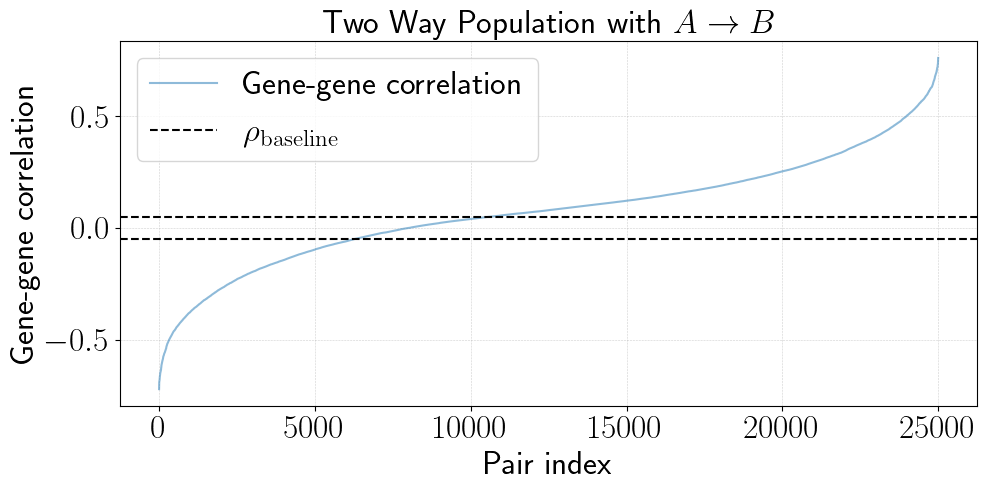

In [48]:
# --- Sort and re-index so x-axis is 0,1,2,… in sorted order -------------
corr_sorted = correlation_df.sort_values('t1_gene_gene_correlation',           # sort
                                         ascending=True) \
                             .reset_index(drop=True)                           # renumber rows
# ------------------------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(
    corr_sorted.index,                           # 0 … N-1  (rank after sorting)
    corr_sorted['t1_gene_gene_correlation'],
    alpha=0.5,
    label='Gene-gene correlation',
)
# plt.plot(
#     corr_sorted.index,                           # 0 … N-1  (rank after sorting)
#     corr_sorted['t1_twin_pair_correlation'],
#     alpha=0.5,
#     label='Twin correlation',
# )

plt.axhline(0.05,  color='black', linestyle='--', label=r'$\rho_{\mathrm{baseline}}$')
plt.axhline(-0.05, color='black', linestyle='--')
plt.xlabel('Pair index')
plt.ylabel('Gene-gene correlation')
plt.title(r'Two Way Population with $A \rightarrow B$')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()

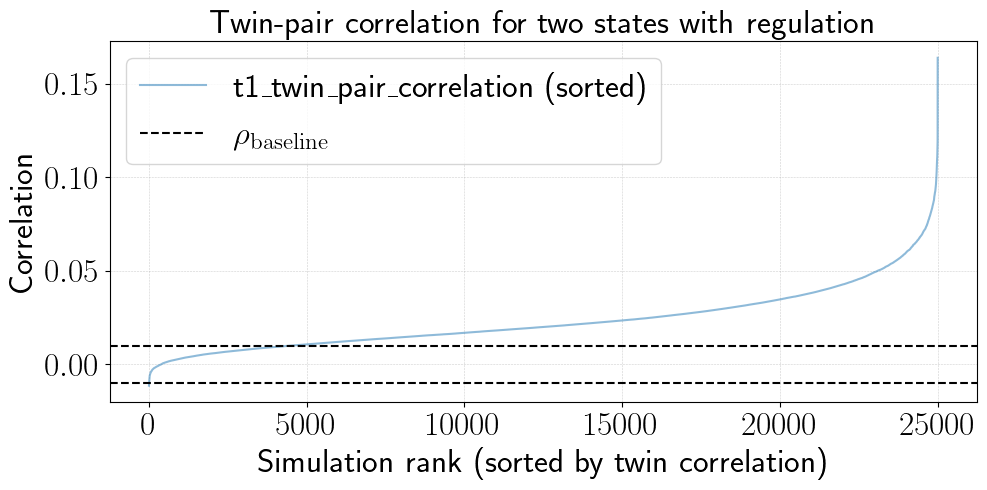

In [49]:
# --- Sort and re-index so x-axis is 0,1,2,… in sorted order -------------
corr_sorted = correlation_df.sort_values('t1_twin_pair_correlation',           # sort
                                         ascending=True) \
                             .reset_index(drop=True)                           # renumber rows
# ------------------------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(
    corr_sorted.index,                           # 0 … N-1  (rank after sorting)
    corr_sorted['t1_twin_pair_correlation'],
    label='t1_twin_pair_correlation (sorted)',
    alpha=0.5
)

plt.axhline(0.01,  color='black', linestyle='--', label=r'$\rho_{\mathrm{baseline}}$')
plt.axhline(-0.01, color='black', linestyle='--')
plt.xlabel('Simulation rank (sorted by twin correlation)')
plt.ylabel('Correlation')
plt.title('Twin-pair correlation for two states with regulation')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()


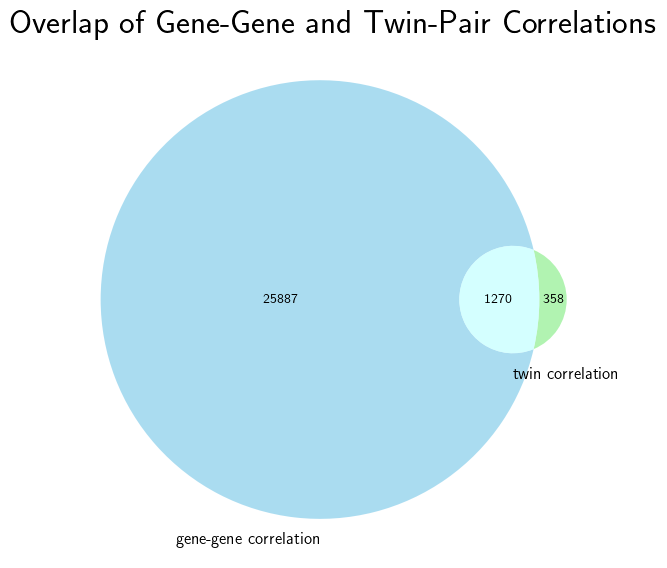

In [32]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Define your sets
gene_gene_high = set(corr_sorted[abs(corr_sorted['t1_gene_gene_correlation']) > 0.05].index)
twin_high = set(corr_sorted[abs(corr_sorted['t2_twin_pair_correlation']) > 0.01].index)

# Create the Venn diagram (venn2 is appropriate here)
plt.figure(figsize=(6, 6))
venn2(
    [gene_gene_high, twin_high],
    set_labels=(r'gene-gene correlation', r'twin correlation'),
    set_colors=("skyblue", "lightgreen"),
    alpha=0.7
)
plt.title("Overlap of Gene-Gene and Twin-Pair Correlations")
plt.tight_layout()
plt.show()


In [40]:
#Count how many gene-gene correlations are greater than 0.05, less than -0.05 and in between
num_greater_than_0_05 = (correlation_df['t1_gene_gene_correlation'] > 0.05).sum()
num_less_than_minus_0_05 = (correlation_df['t1_gene_gene_correlation'] < -0.05).sum()
num_in_between = ((correlation_df['t1_gene_gene_correlation'] <= 0.05) & (correlation_df['t1_gene_gene_correlation'] >= -0.05)).sum()
print(f"Number of gene-gene correlations greater than 0.05: {num_greater_than_0_05/len(correlation_df)}")
print(f"Number of gene-gene correlations less than -0.05: {num_less_than_minus_0_05/len(correlation_df)}")
print(f"Number of gene-gene correlations in between -0.05 and 0.05: {num_in_between/len(correlation_df)}")

Number of gene-gene correlations greater than 0.05: 0.5378388921396529
Number of gene-gene correlations less than -0.05: 0.0
Number of gene-gene correlations in between -0.05 and 0.05: 0.4621611078603472


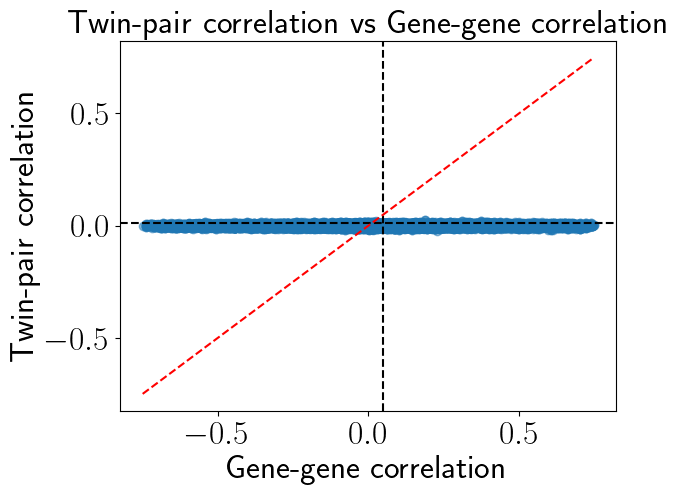

In [33]:
plt.scatter(corr_sorted['t2_gene_gene_correlation'], corr_sorted['t1_twin_pair_correlation'], alpha=0.5)
plt.xlabel('Gene-gene correlation')
plt.ylabel('Twin-pair correlation')
plt.title('Twin-pair correlation vs Gene-gene correlation')
# add a x=y line based on min and max of the data
plt.axhline(0.01, color='black', linestyle='--')
plt.axvline(0.05, color='black', linestyle='--')
min_val = min(corr_sorted['t1_gene_gene_correlation'].min(), corr_sorted['t1_twin_pair_correlation'].min())
max_val = max(corr_sorted['t1_gene_gene_correlation'].max(), corr_sorted['t1_twin_pair_correlation'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x line')
plt.show()


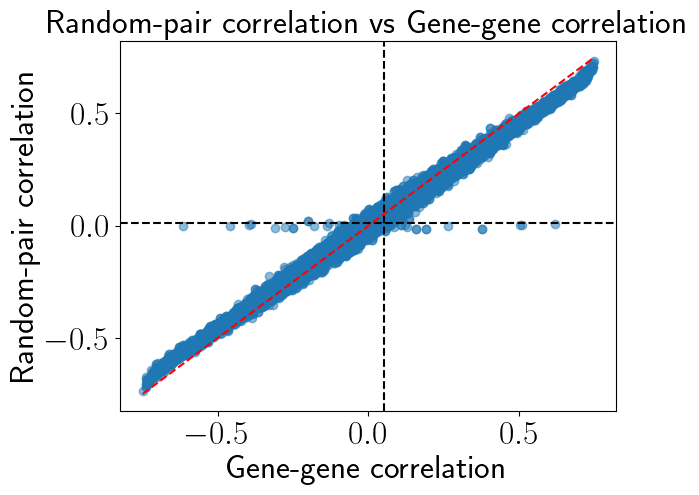

In [34]:
plt.scatter(corr_sorted['t1_gene_gene_correlation'], corr_sorted['t1_random_pair_correlation'], alpha=0.5)
plt.xlabel('Gene-gene correlation')
plt.ylabel('Random-pair correlation')
plt.title('Random-pair correlation vs Gene-gene correlation')
# add a x=y line based on min and max of the data
plt.axhline(0.01, color='black', linestyle='--')
plt.axvline(0.05, color='black', linestyle='--')
min_val = min(corr_sorted['t1_gene_gene_correlation'].min(), corr_sorted['t1_random_pair_correlation'].min())
max_val = max(corr_sorted['t1_gene_gene_correlation'].max(), corr_sorted['t1_random_pair_correlation'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x line')
plt.show()


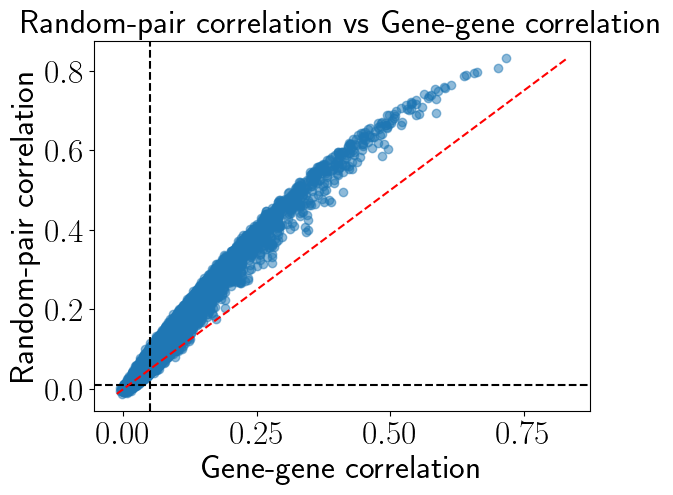

In [10]:
plt.scatter(corr_sorted['t1_gene_gene_correlation'], corr_sorted['t1_random_pair_correlation'], alpha=0.5)
plt.xlabel('Gene-gene correlation')
plt.ylabel('Random-pair correlation')
plt.title('Random-pair correlation vs Gene-gene correlation')
# add a x=y line based on min and max of the data
plt.axhline(0.01, color='black', linestyle='--')
plt.axvline(0.05, color='black', linestyle='--')
min_val = min(corr_sorted['t1_gene_gene_correlation'].min(), corr_sorted['t1_random_pair_correlation'].min())
max_val = max(corr_sorted['t1_gene_gene_correlation'].max(), corr_sorted['t1_random_pair_correlation'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x line')
plt.show()


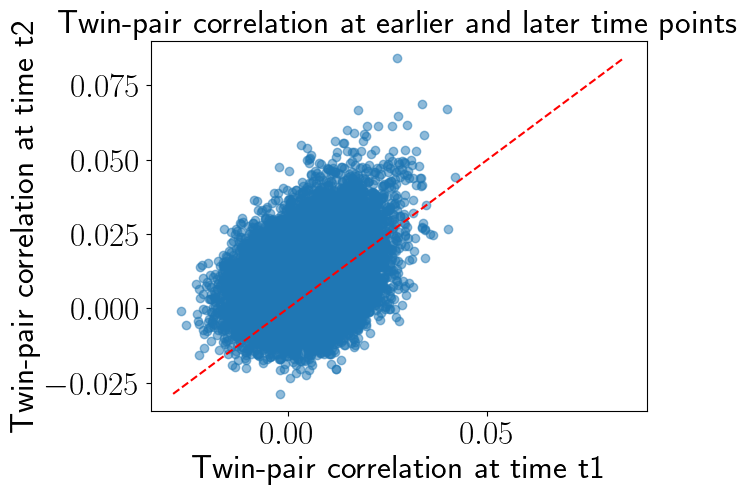

In [39]:
plt.scatter(corr_sorted['t1_twin_pair_correlation'], corr_sorted['t2_twin_pair_correlation'], alpha=0.5)
plt.xlabel('Twin-pair correlation at time t1')
plt.ylabel('Twin-pair correlation at time t2')
plt.title('Twin-pair correlation at earlier and later time points')
# add a x=y line based on min and max of the data
min_val = min(corr_sorted['t2_twin_pair_correlation'].min(), corr_sorted['t1_twin_pair_correlation'].min())
max_val = max(corr_sorted['t2_twin_pair_correlation'].max(), corr_sorted['t1_twin_pair_correlation'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x line')
plt.show()


In [52]:
corr_sorted[(corr_sorted['t1_twin_pair_correlation']< corr_sorted['t2_twin_pair_correlation']) & ((corr_sorted['t2_twin_pair_correlation']) > 0.01) & (abs(corr_sorted['t1_gene_gene_correlation']) > 0.05)]

,param_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
7,3058,0.061492,-0.020559,0.117014,0.070450,0.011790,0.134187
17,10110,0.126910,-0.018127,0.232701,0.130676,0.015674,0.227294
23,15495,0.262681,-0.017333,0.413190,0.266471,0.015326,0.418658
25,5836,0.061274,-0.017282,0.109403,0.065217,0.014137,0.115501
33,451,0.222695,-0.016647,0.283157,0.219089,0.012516,0.280581
...,...,...,...,...,...,...,...
10242,7632,0.374115,0.030957,0.509988,0.368822,0.034641,0.508514
10243,541,0.104586,0.031081,0.100979,0.098072,0.068752,0.103512
10246,5229,0.277626,0.032076,0.362238,0.275162,0.074143,0.365993
10249,17963,0.103182,0.034231,0.117394,0.098592,0.038906,0.113307


In [50]:
4305/corr_sorted.shape[0]

0.419836161497952

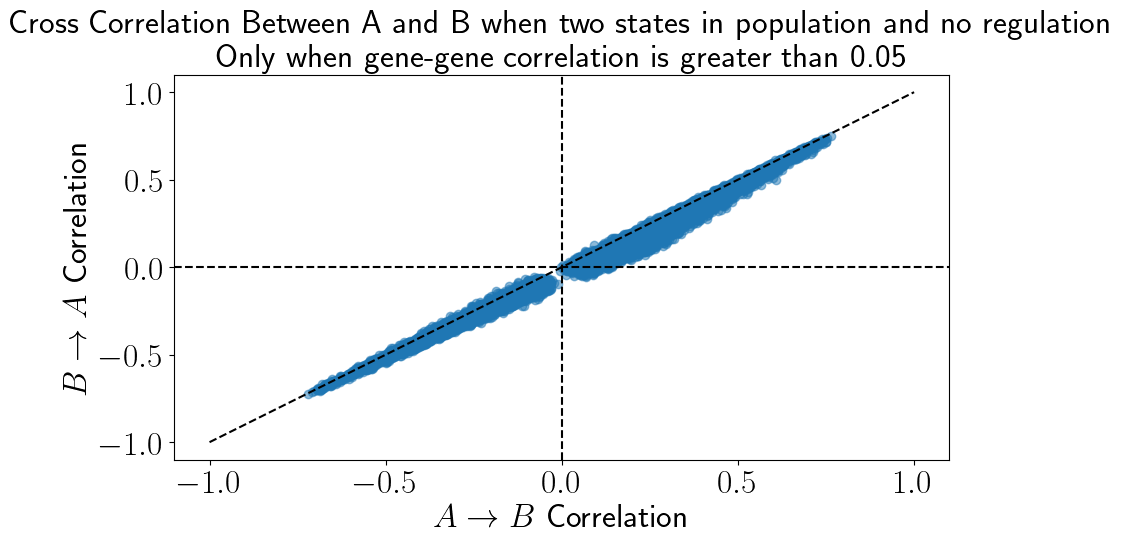

In [53]:
#Filter cross-correlation based whether twins showed correlation
corr_filtered = corr_sorted[abs(corr_sorted['t1_gene_gene_correlation']) > 0.05]
#Pair two columns in a df and store it
# param_1_2_pair = (corr_filtered['param_index'])
param_1_2_pair = list(zip(corr_filtered['parameter_index_1'], corr_filtered['parameter_index_2']))
#Now filter cross-correlation based on this list of pairs
cross_correlation_df['pair'] = list(zip(cross_correlation_df['parameter_index_1'], cross_correlation_df['parameter_index_2']))
cross_correlation_df_filtered = cross_correlation_df[cross_correlation_df['pair'].isin(param_1_2_pair)]
#Scatter plot the cross correlations
plt.figure(figsize=(10, 5))
plt.scatter(cross_correlation_df_filtered['TF_t1_Target_t2_twin'], cross_correlation_df_filtered['Target_t1_TF_t2_twin'], alpha=0.5)
plt.xlabel(r"$A \rightarrow B$ Correlation")
plt.ylabel(r"$B \rightarrow A$ Correlation")
plt.title('Cross Correlation Between A and B when two states in population and no regulation\n Only when gene-gene correlation is greater than 0.05')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
#Add a x=y line
plt.plot([-1, 1], [-1, 1], color='black', linestyle='--')
plt.show()


In [67]:
print(cross_correlation_df_filtered.shape[0])
cross_correlation_df_filtered[(cross_correlation_df_filtered['TF_t1_Target_t2_twin'] > 0) & (cross_correlation_df_filtered['TF_t1_Target_t2_twin'] > cross_correlation_df_filtered['Target_t1_TF_t2_twin'])].shape[0]

14390


14171

In [68]:
14171/14390

0.9847810979847116

In [30]:
corr_sorted.shape

(10259, 7)

In [22]:
corr_filtered = corr_sorted[abs(corr_sorted['t1_twin_pair_correlation']) > 0.01]
corr_filtered 

,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation,parameter_index_1,parameter_index_2
0,0.215233,-0.022894,0.229007,0.225906,0.001860,0.234892,2892,14838
1,0.601783,-0.020680,0.547314,0.605508,0.004381,0.543724,9692,14838
2,0.601783,-0.020680,0.547314,0.605508,0.004381,0.543724,9692,14838
3,0.593175,-0.019217,0.534374,0.593842,-0.003499,0.538258,12719,19384
4,0.096165,-0.018372,0.095355,0.101978,-0.006897,0.101540,9095,12585
...,...,...,...,...,...,...,...,...
35245,0.315351,0.019057,0.303613,0.311610,0.002007,0.291932,887,7644
35246,0.389949,0.020143,0.377774,0.374856,-0.004845,0.363686,12361,8793
35247,0.389949,0.020143,0.377774,0.374856,-0.004845,0.363686,12361,8793
35248,0.195306,0.022868,0.197430,0.185997,-0.007625,0.192123,8793,21670


In [ ]:
#Filter cross-correlation based whether twins showed correlation
corr_filtered = corr_sorted[(abs(corr_sorted['t2_twin_pair_correlation']) > 0.01) & (abs(corr_sorted['t1_gene_gene_correlation']) > 0.05)]
param_1_2_pair = (corr_filtered['param_index'])
# param_1_2_pair = list(zip(corr_filtered['parameter_index_1'], corr_filtered['parameter_index_2']))
#Now filter cross-correlation based on this list of pairs
# cross_correlation_df['pair'] = list(zip(cross_correlation_df['parameter_index_1'], cross_correlation_df['parameter_index_2']))
cross_correlation_df_filtered = cross_correlation_df[cross_correlation_df['param_index'].isin(param_1_2_pair)]
print(cross_correlation_df_filtered.shape[0])
#Scatter plot the cross correlations
plt.figure(figsize=(10, 5))
plt.scatter(cross_correlation_df_filtered['TF_t1_Target_t2_twin'], cross_correlation_df_filtered['Target_t1_TF_t2_twin'], alpha=0.5, label = "one parameter set")
plt.xlabel(r"$A_{t1} \rightarrow B_{t2}$ Correlation")
plt.ylabel(r"$B_{t1} \rightarrow A_{t2}$ Correlation")
plt.title('Cross Correlation Between A and B when two states in population \n When there is gene-gene and twin pair correlations')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
#Add a x=y line
plt.plot([-1, 1], [-1, 1], color='black', linestyle='--')
#Add text that one point is one parameter pair as legend
plt.legend()
plt.show()


In [89]:
difference = (cross_correlation_df_filtered['TF_t1_Target_t2_twin'] - cross_correlation_df_filtered['Target_t1_TF_t2_twin'])
#Calculate abs mean and std of the difference
mean_difference = abs(difference).mean()
std_difference = abs(difference).std()
print(f"Mean absolute difference: {mean_difference}")
print(f"Standard deviation of absolute difference: {std_difference}")


Mean absolute difference: 0.010966689015380348
Standard deviation of absolute difference: 0.009049100186116486


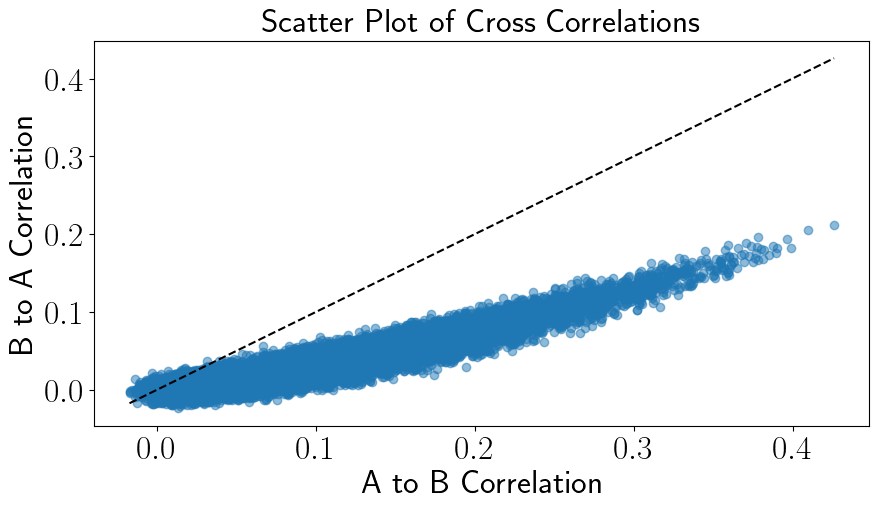

In [19]:
#Scatter plot of the two cross correlations
plt.figure(figsize=(10, 5))

plt.scatter(cross_correlation_df['TF_t1_Target_t2_twin'], cross_correlation_df['Target_t1_TF_t2_twin'], alpha=0.5)
plt.xlabel(r'A to B Correlation')
plt.ylabel(r'B to A Correlation')
plt.title('Scatter Plot of Cross Correlations')
#Add a x=y line
plt.plot([cross_correlation_df['TF_t1_Target_t2_twin'].min(), cross_correlation_df['TF_t1_Target_t2_twin'].max()],
         [cross_correlation_df['TF_t1_Target_t2_twin'].min(), cross_correlation_df['TF_t1_Target_t2_twin'].max()],
         color='black', linestyle='--', label='y=x line')
plt.show()